# Variational Auto-Encoder on Robot Images

In [1]:
import conx as cx
import keras.backend as K
import pickle

Using TensorFlow backend.
Conx, version 3.7.3


We need a function to use as the activation function for the Sampler layer:

In [2]:
data = pickle.load(open("dataset4.pickle", "rb"))

In [3]:
data[0]

(0.0, 0.5, <PIL.Image.Image image mode=RGBA size=427x266 at 0x7F086724EA20>)

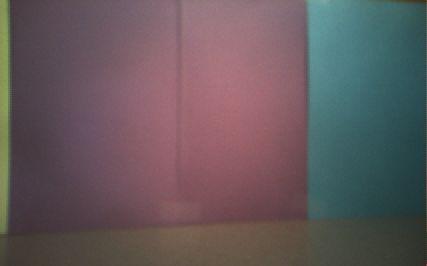

In [4]:
data[0][2]

In [5]:
inputs = [cx.image_to_array(row[2], resize=(60,40)) for row in data]
targets = [cx.reshape(input, new_shape=(40 * 60 * 3)) for input in inputs]

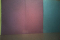

In [6]:
cx.array_to_image(targets[0], shape=(40, 60, 3))

In [32]:
LENGTH = 25 # latent size

In [33]:
def sampler(inputs):
    ## inputs is a merged concat
    mean, log_stddev = inputs[:, :LENGTH], inputs[:, LENGTH:]
    # we sample from the standard normal a matrix of batch_size * latent_size (taking into account minibatches)
    std_norm = K.random_normal(shape=(K.shape(mean)[0], LENGTH), mean=0, stddev=1)
    # sampling from Z~N(μ, σ^2) is the same as sampling from μ + σX, X~N(0,1)
    return mean + K.exp(log_stddev) * std_norm

In [34]:
net = cx.Network("vae on images")
net.add(
    cx.ImageLayer("input", (40,60), 3),
    cx.FlattenLayer("flatten"),
    cx.Layer("hidden1", 50),
    cx.Layer("mean", LENGTH),
    cx.Layer("log_stddev", LENGTH),
    cx.LambdaLayer("encode", LENGTH, sampler), # function, that takes input layer's output
    cx.Layer("hidden2", 50),
    cx.Layer("output", 40*60*3, vshape=(40, 60, 3), keep_aspect_ratio=True),
)    

'output'

In [35]:
net.connect("input", "flatten")
net.connect("flatten", "hidden1")
net.connect("hidden1", "mean")
net.connect("hidden1", "log_stddev")
net.connect("mean", "encode")
net.connect("log_stddev", "encode")
net.connect("encode", "hidden2")
net.connect("hidden2", "output")

To allow an additional error function, we need to declare "encode" (an internal bank) as an output:

In [36]:
net.build_model()

In [37]:
net.additional_output_banks = ["encode"]

And then we can provide a dictionary of error functions by name:

In [38]:
net.compile(error="mse", optimizer="adam")

In [39]:
net.dataset.load(inputs=inputs, targets=targets)


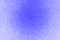
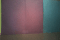

In [44]:
net.picture(net.dataset.inputs[0], scale=0.8, hspace=200)

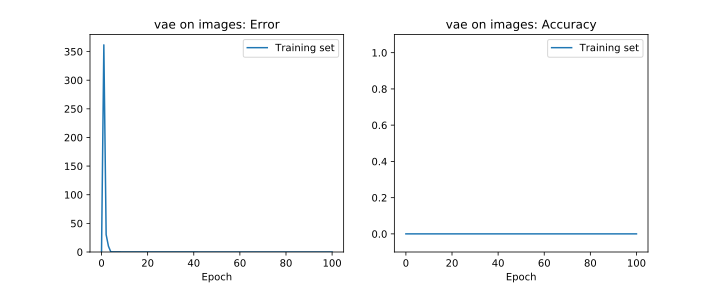

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  100 |   0.01371 |   0.00000 


In [43]:
net.train(100)